# Testing Synthetic Motion Parameters

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [687]:
import nibabel as nb
import numpy as np
import cv2
import pandas as pd

#import pymatbridge as pymat
#from pymatbridge import Matlab
#pymat.load_ipython_extension(get_ipython(), matlab='/Applications/MATLAB_R2018a.app/bin/matlab')

In [688]:
in_nifti = '../data/285345.T1w_restore_brain.nii.gz'
img = nb.load(in_nifti)
data = img.get_data()
print('Shape: {:}'.format(data.shape))

Shape: (260, 311, 260)


In [689]:
data = np.fliplr(data)
data = np.swapaxes(data,0,2)

In [690]:
D = data[130,:,:]
D = (D-D.min())/D.max()

In [10]:
transform_matrix = np.array([[1,0,20],[0,1,0]]).astype(np.float32)
temp = cv2.warpAffine(D,transform_matrix,D.T.shape)

# Translations

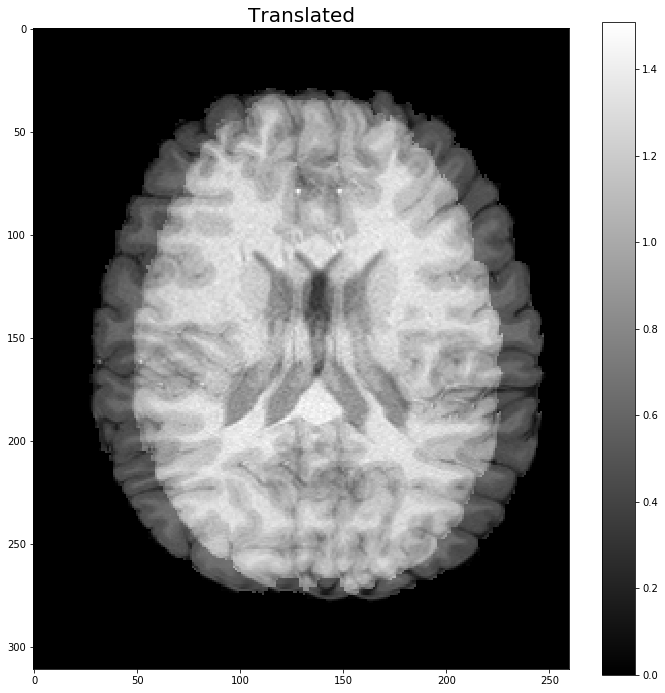

In [23]:
fig = plt.figure(figsize=(12,12))
plt.imshow(translated+D, cmap='gray')
plt.colorbar()
plt.title('Translated', fontsize=20)
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/openCV/translated.jpg')

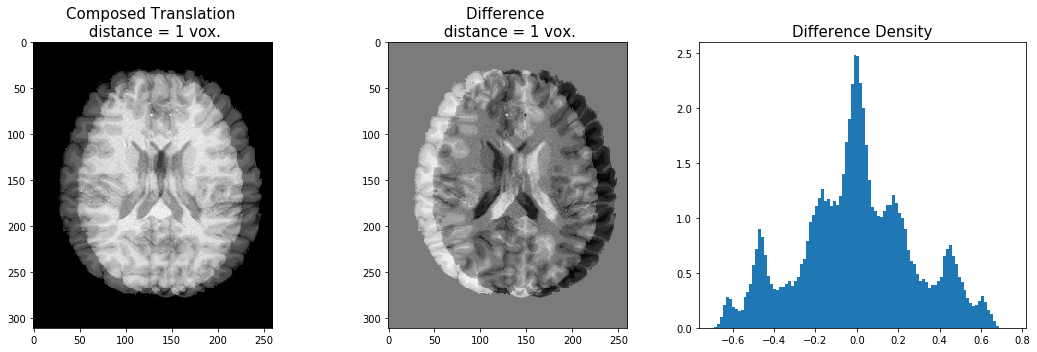

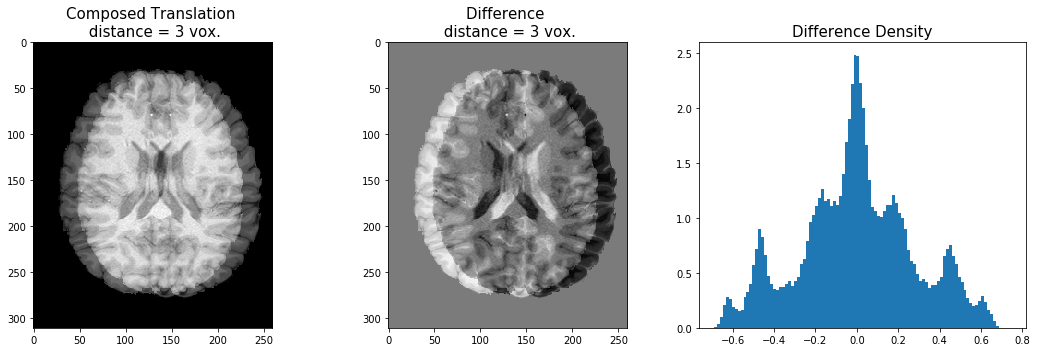

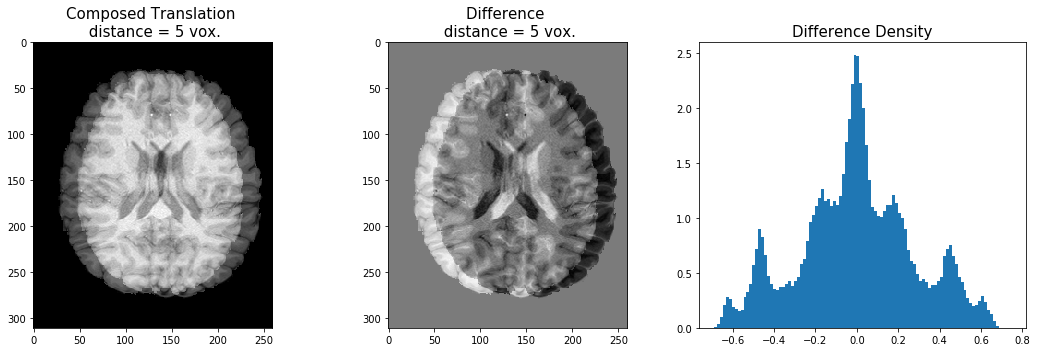

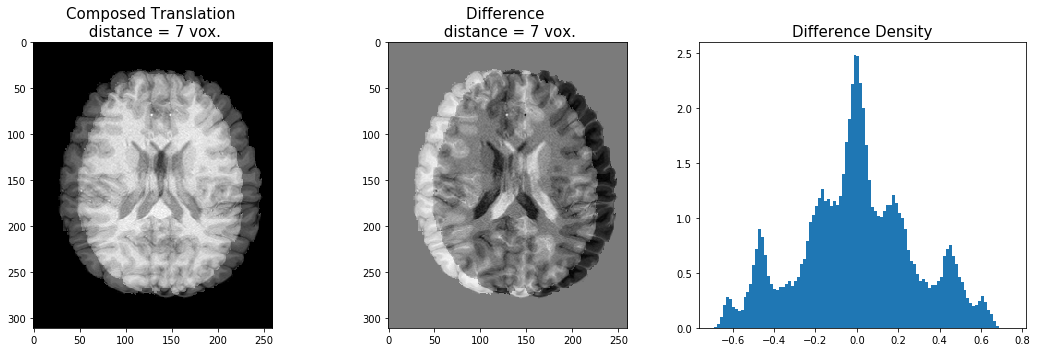

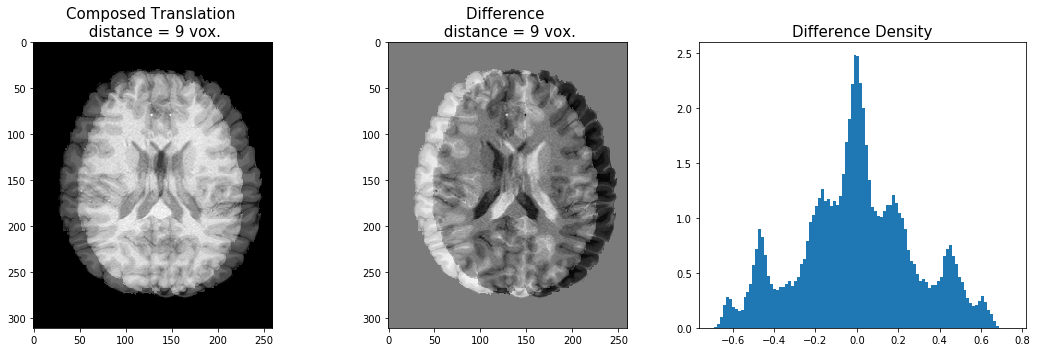

In [12]:
rows,cols = D.shape
for trans in [1,3,5,7,9]:
    T = np.array([[1,0,20],[0,1,0]]).astype(np.float32)
    translated = cv2.warpAffine(D,T,D.T.shape)
    difference = D-translated
    res = difference.reshape(np.product(difference.shape))
    fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))
    ax1.imshow(translated+D, cmap='gray')
    ax1.set_title('Composed Translation \n distance = {:} vox.'.format(trans), fontsize=15)
    ax2.imshow(D-translated, cmap='gray')
    ax2.set_title('Difference \n distance = {:} vox.'.format(trans), fontsize=15)
    ax3.hist(res[res!=0],100,density=True)
    ax3.set_title('Difference Density', fontsize=15)
    plt.tight_layout()
    plt.show()

# Rotations

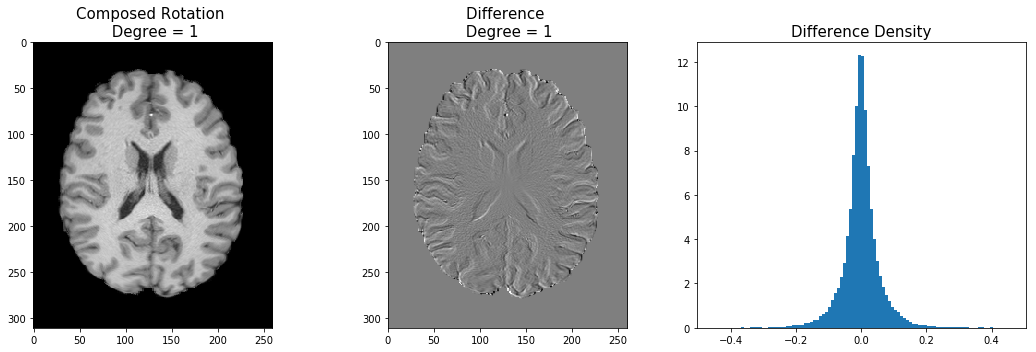

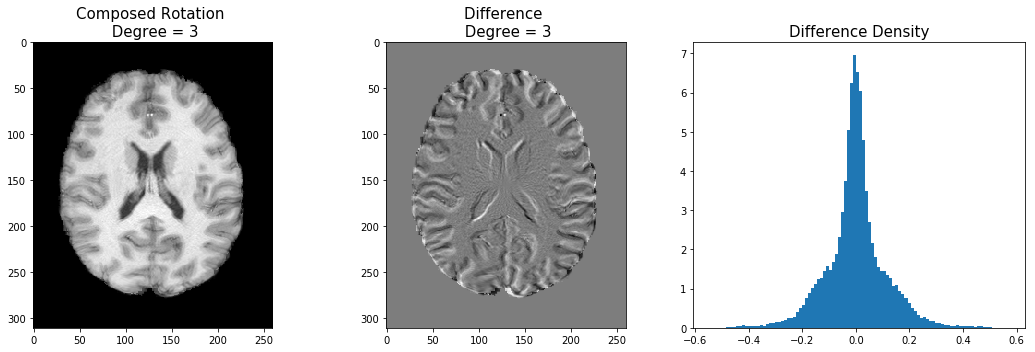

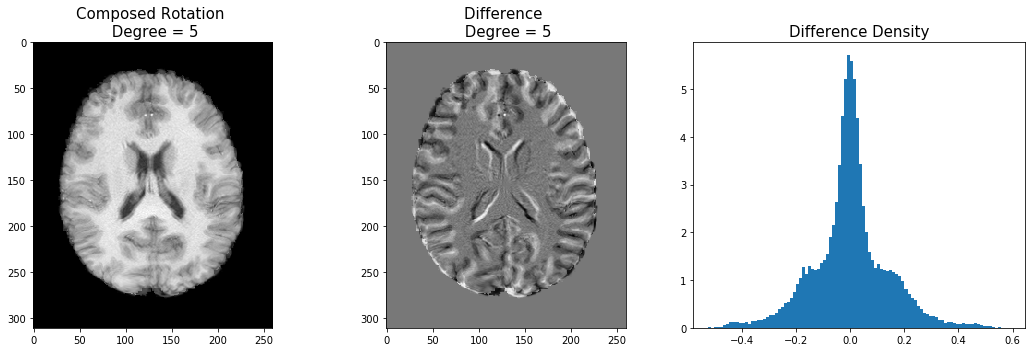

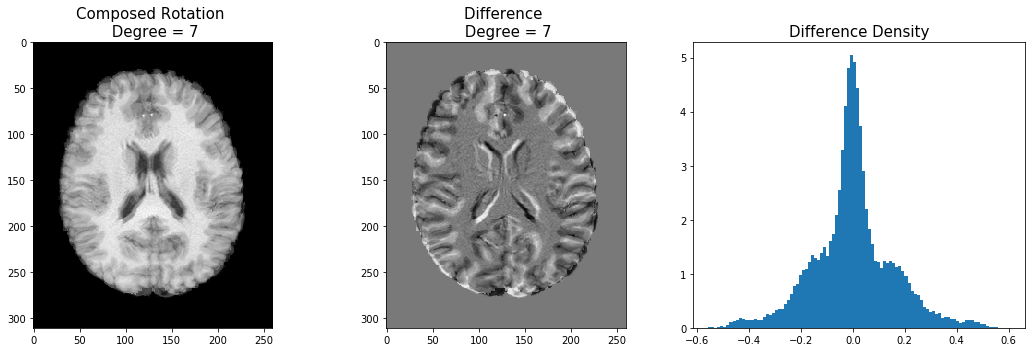

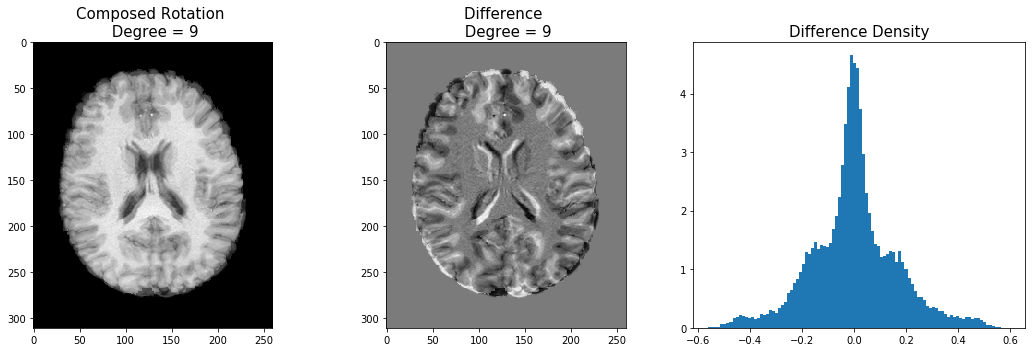

In [12]:
rows,cols = D.shape
for rot in [1,3,5,7,9]:
    M = cv2.getRotationMatrix2D((cols/2,rows/2),rot,1) 
    rotated = cv2.warpAffine(D,M,D.T.shape)
    difference = D-rotated
    res = difference.reshape(np.product(difference.shape))
    fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))
    ax1.imshow(rotated+D, cmap='gray')
    ax1.set_title('Composed Rotation \n Degree = {:}'.format(rot), fontsize=15)
    ax2.imshow(D-rotated, cmap='gray')
    ax2.set_title('Difference \n Degree = {:}'.format(rot), fontsize=15)
    ax3.hist(res[res!=0],100,density=True)
    ax3.set_title('Difference Density', fontsize=15)
    plt.tight_layout()
    plt.show()

# Rotation + Translations with Random +/- change in degree / translation

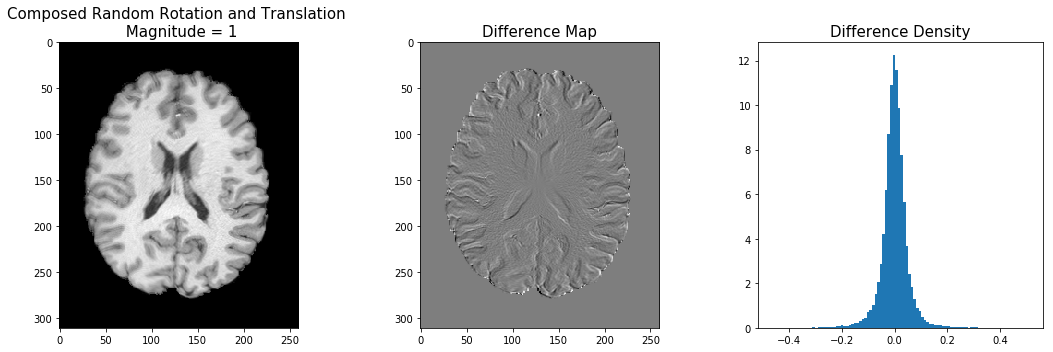

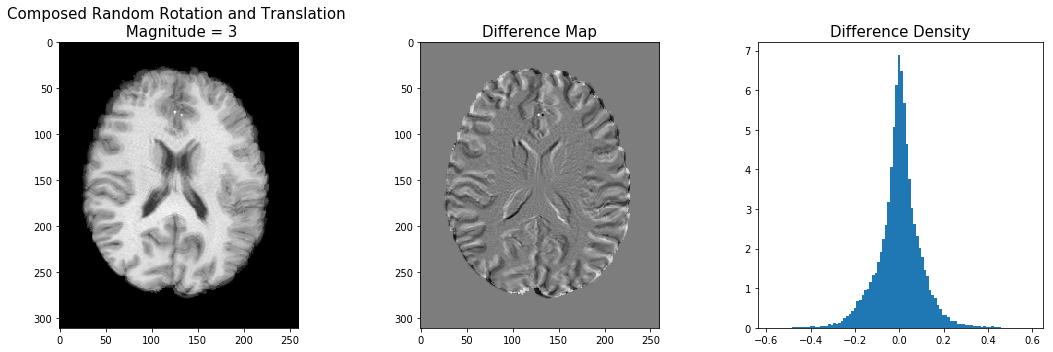

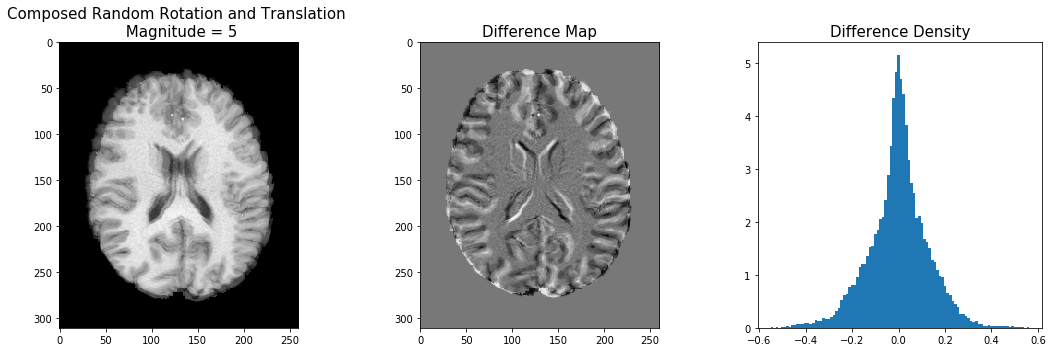

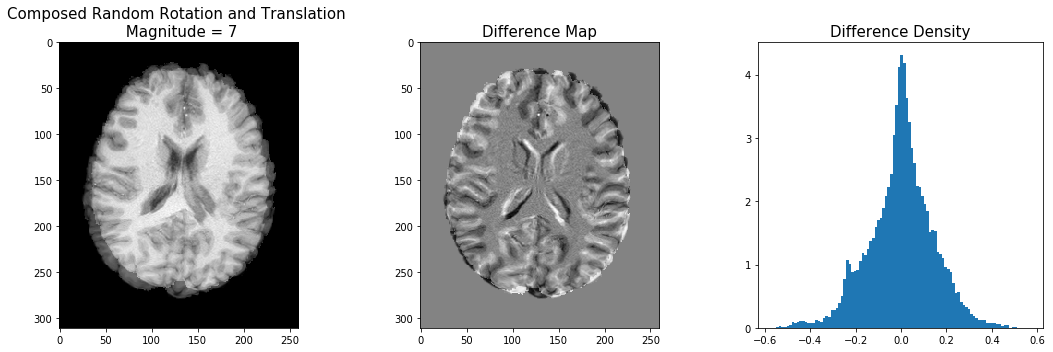

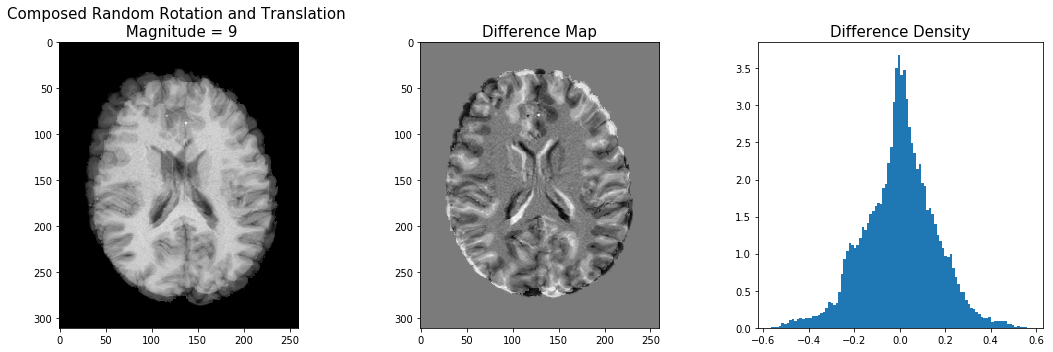

In [10]:
rows,cols = D.shape
for rt in [1,3,5,7,9]:
    M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.choice([-1,1],1)[0]*rt,1) 
    rotated = cv2.warpAffine(D,M,D.T.shape)
    T = np.array([[1,0,np.random.choice([-1,1],1)[0]*rt],[0,1,np.random.choice([-1,1],1)[0]*rt]]).astype(np.float32)
    translated = cv2.warpAffine(D,T,D.T.shape)
    
    movement = (rotated + translated)/2
    
    difference = D-movement
    res = difference.reshape(np.product(difference.shape))
    fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))
    ax1.imshow(movement, cmap='gray')
    ax1.set_title('Composed Random Rotation and Translation \n Magnitude = {:}'.format(rt), fontsize=15)
    ax2.imshow(D-rotated, cmap='gray')
    ax2.set_title('Difference Map'.format(rt), fontsize=15)
    ax3.hist(res[res!=0],100,density=True)
    ax3.set_title('Difference Density', fontsize=15)
    plt.tight_layout()
    if rt in [1,5,9]:
        plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/openCV/Composed.{:}.jpg'.format(rt))
    plt.show()
    

In [710]:
prefilt = '../data/prefiltered_func_data_mcf.par'
df = pd.read_table(prefilt,names=['xrad','yrad','zrad','xshift','yshift','zshift'],sep='\s+')

motion = np.asarray(df)
mu = motion.mean(0)
cov = np.cov(motion.T)
mvn = multivariate_normal(mean=mu,cov=cov)

Text(0.5,1,'Translations (mm)')

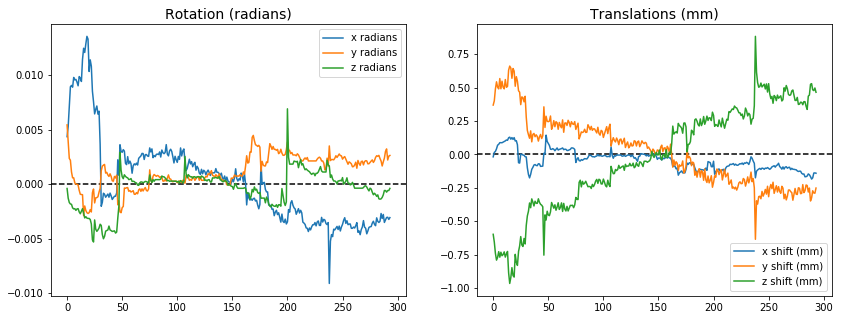

In [664]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(14,5))
ax1.axhline(y=0,c='k',linestyle='--')
ax1.plot(df['xrad'], label='x radians')
ax1.plot(df['yrad'], label='y radians')
ax1.plot(df['zrad'], label='z radians')
ax1.legend()
ax1.set_title('Rotation (radians)', fontsize=14)

ax2.axhline(y=0,c='k',linestyle='--')
ax2.plot(df['xshift'], label='x shift (mm)')
ax2.plot(df['yshift'], label='y shift (mm)')
ax2.plot(df['zshift'], label='z shift (mm)')
ax2.legend()
ax2.set_title('Translations (mm)', fontsize=14)

In [12]:
from scipy.stats import multivariate_normal

In [669]:
from glob import glob
import os
os.chdir('/Users/kristianeschenburg/Documents/Code/DeepImageRecon/synthetics/')

from make_affine import makeFslXfmMatrix
from fsl_wrappers import flirt
from maths import add

In [670]:
out_dir = '/Users/kristianeschenburg/Desktop/transformation_testing/'
in_image = '/Users/kristianeschenburg/Documents/Code/DeepImageRecon/data/285345.T1w_restore_brain.nii.gz'

Text(0.5,1,'Unweighted Sample Translations (mm)')

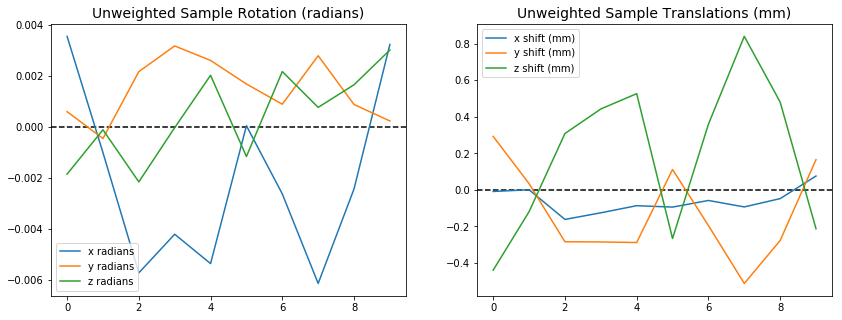

In [723]:
# unweighted rotations
weight = 1
samples = mvn.rvs(size=10)
samples = pd.DataFrame(samples,columns=['xrad','yrad','zrad','xshift','yshift','zshift'])

for l in np.arange(len(samples)):
    
    ig = in_image
    og = ''.join([out_dir,'TransformedImage.Unweighted.{:}.nii.gz'.format(l+1)])
    oxfm = ''.join([out_dir,'Transformation.Unweighted.{:}.mat'.format(l+1)])
    
    make_affine.makeFslXfmMatrix(weight*np.asarray(samples.iloc[l,3:6]), 
                                 weight*np.asarray(samples.iloc[l,0:3]), 
                                 np.asarray([1,1,1]), oxfm)
    
    fsl_wrappers.flirt(in_image, in_image, og, oxfm)

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(14,5))
ax1.axhline(y=0,c='k',linestyle='--')
ax1.plot(weight*samples['xrad'], label='x radians')
ax1.plot(weight*samples['yrad'], label='y radians')
ax1.plot(weight*samples['zrad'], label='z radians')
ax1.legend()
ax1.set_title('Unweighted Sample Rotation (radians) \n ', fontsize=14)

ax2.axhline(y=0,c='k',linestyle='--')
ax2.plot(weight*samples['xshift'], label='x shift (mm)')
ax2.plot(weight*samples['yshift'], label='y shift (mm)')
ax2.plot(weight*samples['zshift'], label='z shift (mm)')
ax2.legend()
ax2.set_title('Unweighted Sample Translations (mm)', fontsize=14)

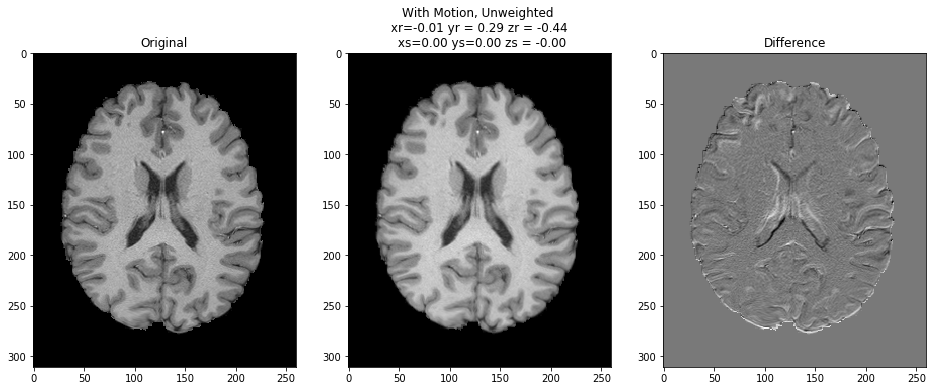

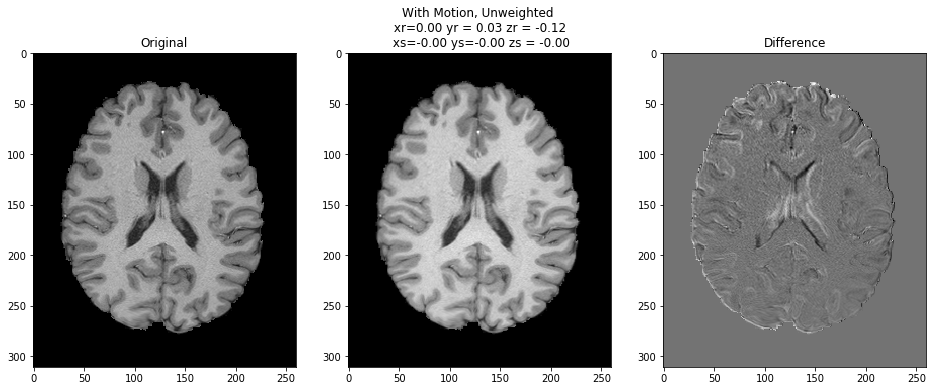

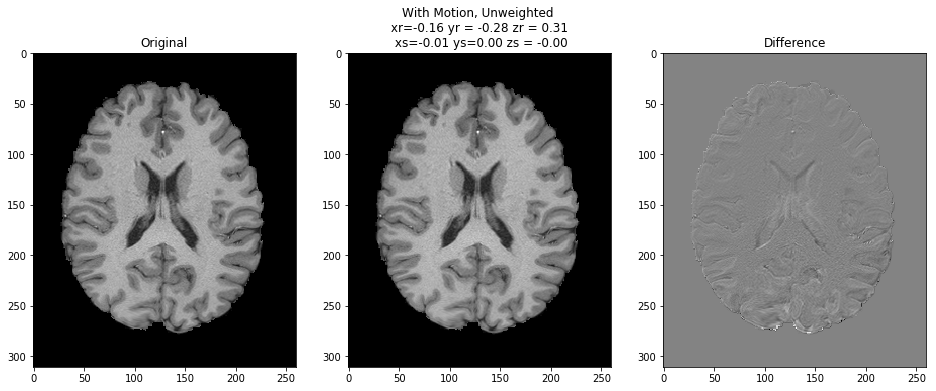

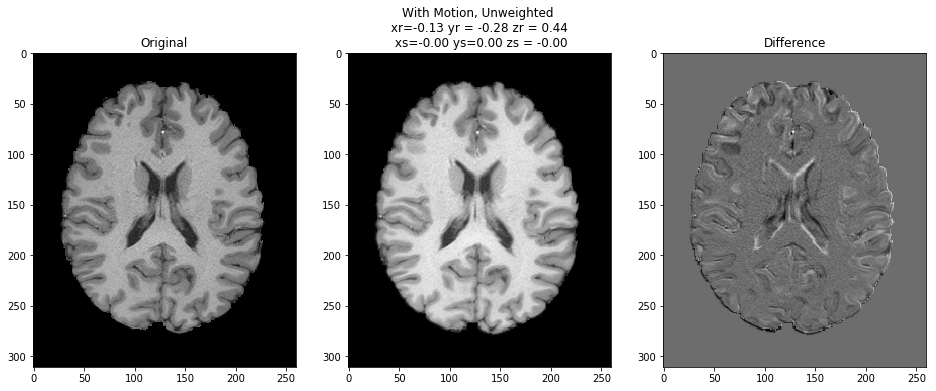

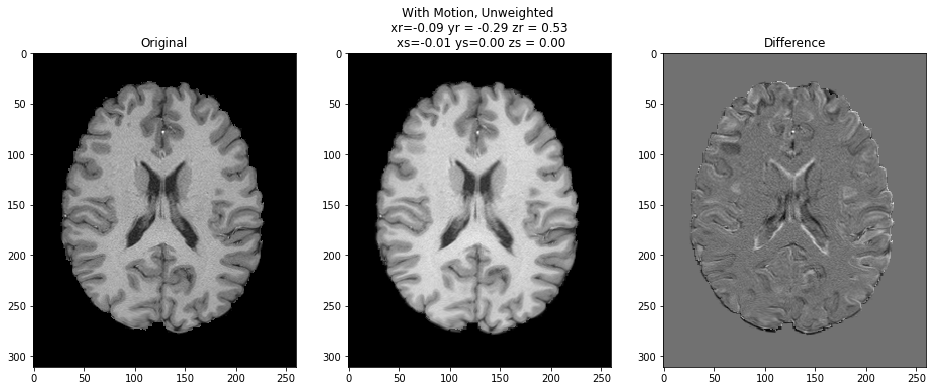

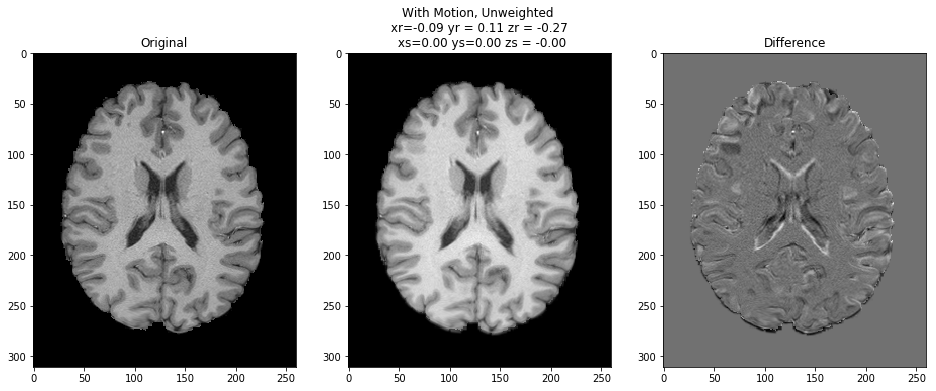

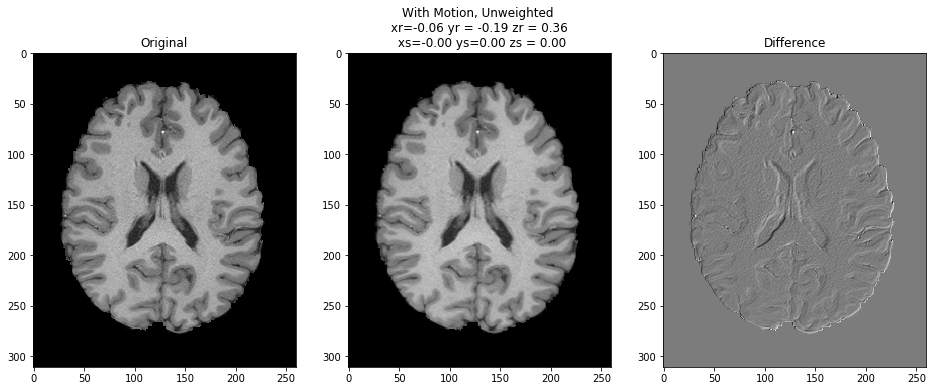

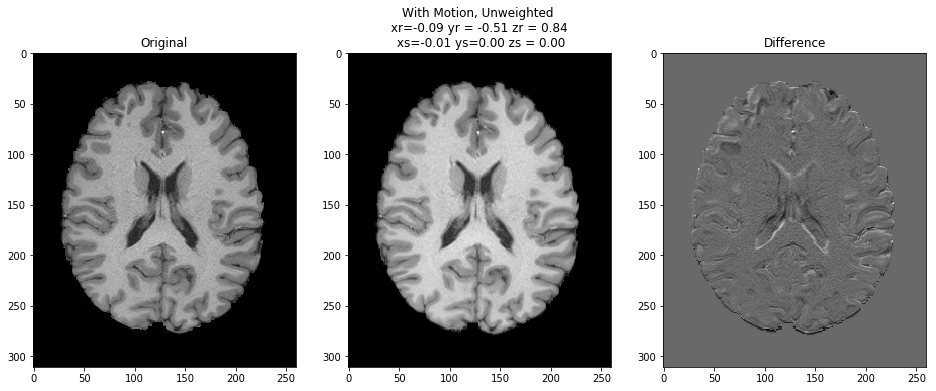

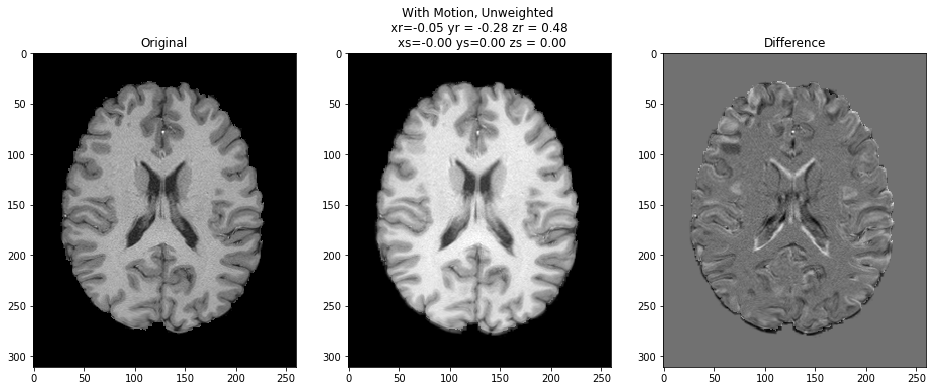

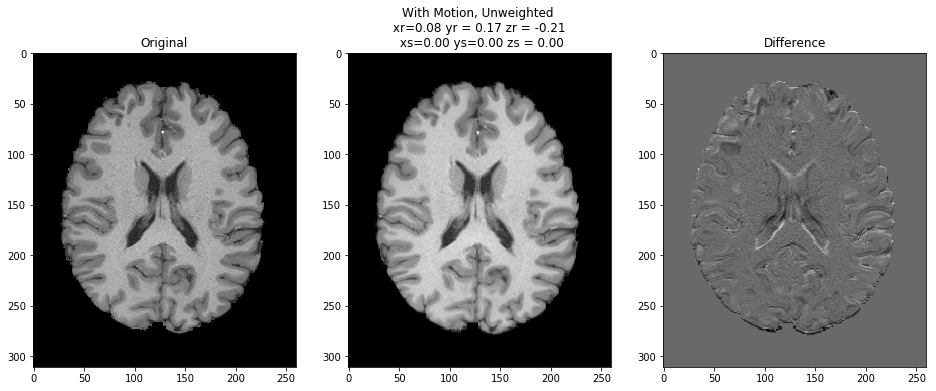

In [729]:
G = glob('/Users/kristianeschenburg/Desktop/transformation_testing/TransformedImage.Unweighted.*.gz')

for i,g in enumerate(G):
    [og, cg] = add(in_image, [g], weights = [1])
    
    og = np.fliplr(og)
    og = np.swapaxes(og,0,2)
    
    cg = np.fliplr(cg)
    cg = np.swapaxes(cg,0,2)
    
    
    fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(16,8))
    ax1.imshow(og[130,:,:],cmap='gray');
    ax1.set_title('Original')
    ax2.imshow(cg[130,:,:]/2,cmap='gray');
    titled = 'With Motion, Unweighted \n xr=%.2f yr = %.2f zr = %.2f \n xs=%.2f ys=%.2f zs = %.2f' % (samples.iloc[i,3], 
            samples.iloc[i,4],samples.iloc[i,5], samples.iloc[i,0], samples.iloc[i,1], samples.iloc[i,2])
    ax2.set_title(titled)
    ax3.imshow(og[130,:,:] - cg[130,:,:]/2,cmap='gray')
    ax3.set_title('Difference')
    plt.show()

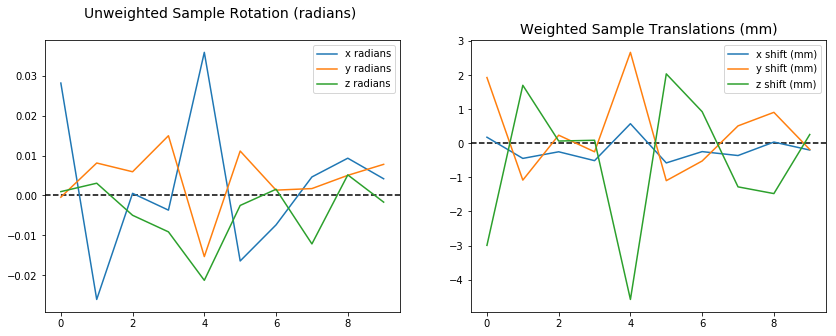

In [739]:
# unweighted rotations
weight = 5
samples = weight*mvn.rvs(size=10)
samples = pd.DataFrame(samples,columns=['xrad','yrad','zrad','xshift','yshift','zshift'])

for l in np.arange(len(samples)):
    
    ig = in_image
    og = ''.join([out_dir,'TransformedImage.Weighted.{:}.{:}.nii.gz'.format(weight,l+1)])
    oxfm = ''.join([out_dir,'Transformation.Weighted.{:}.{:}.mat'.format(weight,l+1)])
    
    make_affine.makeFslXfmMatrix(np.asarray(samples.iloc[l,3:6]), 
                                 np.asarray(samples.iloc[l,0:3]), 
                                 np.asarray([1,1,1]), oxfm)
    
    fsl_wrappers.flirt(in_image, in_image, og, oxfm)

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(14,5))
ax1.axhline(y=0,c='k',linestyle='--')
ax1.plot(samples['xrad'], label='x radians')
ax1.plot(samples['yrad'], label='y radians')
ax1.plot(samples['zrad'], label='z radians')
ax1.legend()
ax1.set_title('Unweighted Sample Rotation (radians) \n ', fontsize=14)

ax2.axhline(y=0,c='k',linestyle='--')
ax2.plot(samples['xshift'], label='x shift (mm)')
ax2.plot(samples['yshift'], label='y shift (mm)')
ax2.plot(samples['zshift'], label='z shift (mm)')
ax2.legend()
ax2.set_title('Weighted Sample Translations (mm)', fontsize=14)

G = glob('/Users/kristianeschenburg/Desktop/transformation_testing/TransformedImage.Weighted.{:}.*.gz'.format(weight))

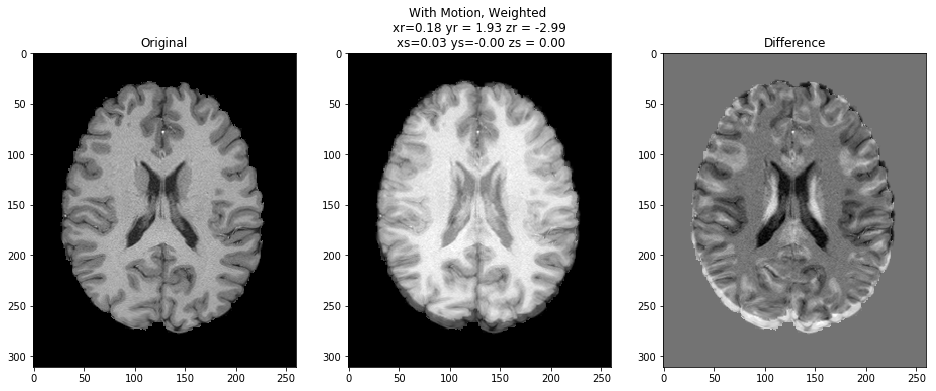

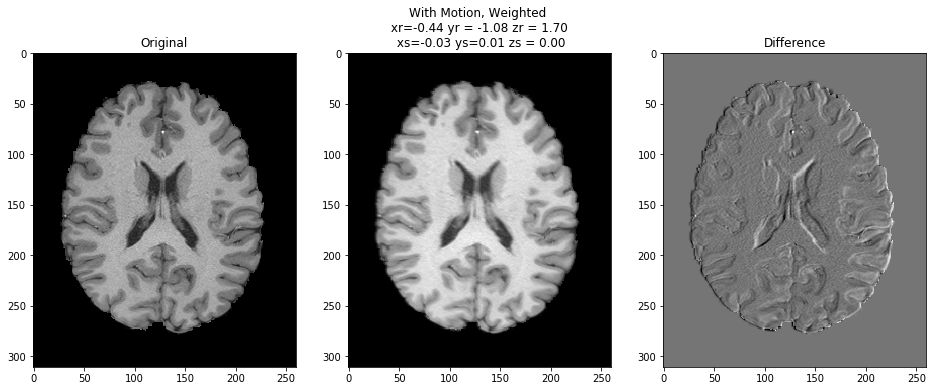

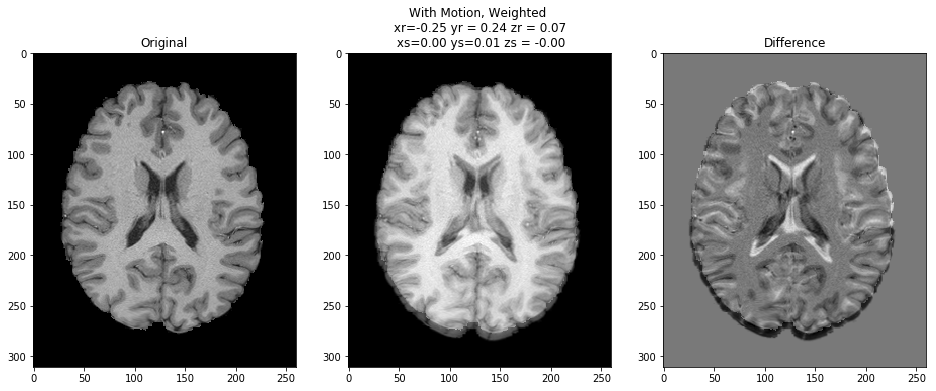

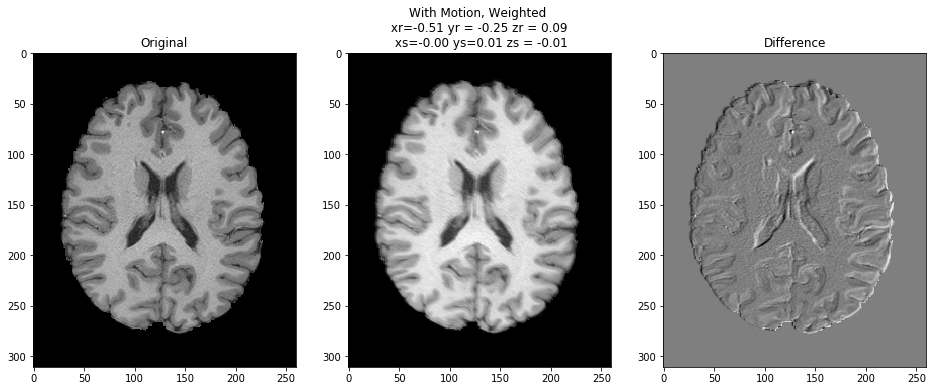

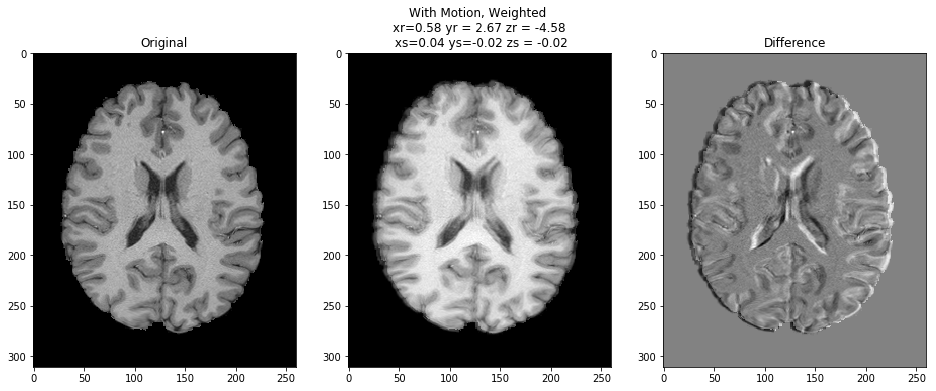

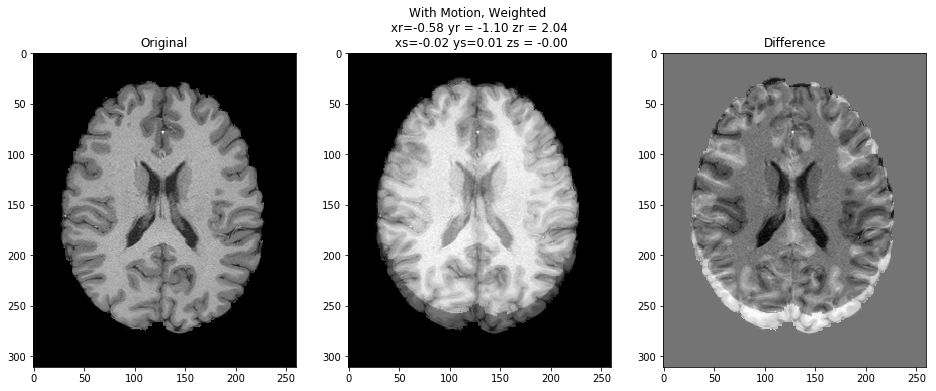

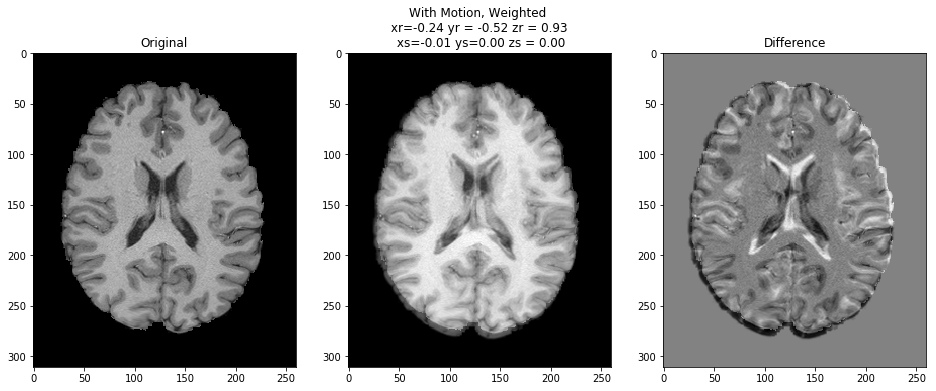

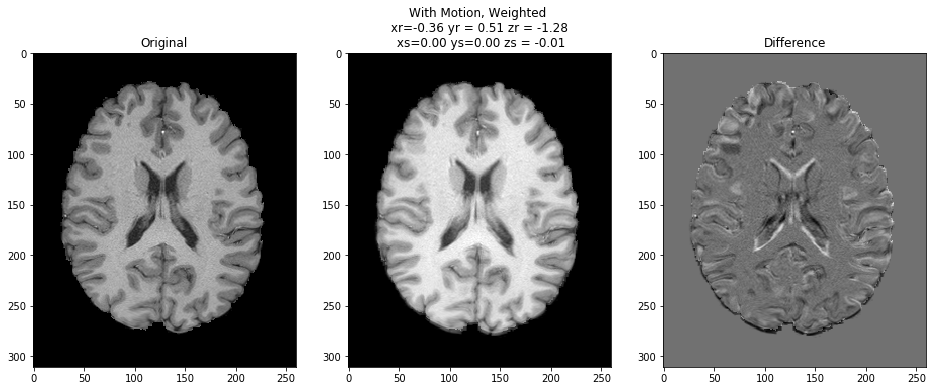

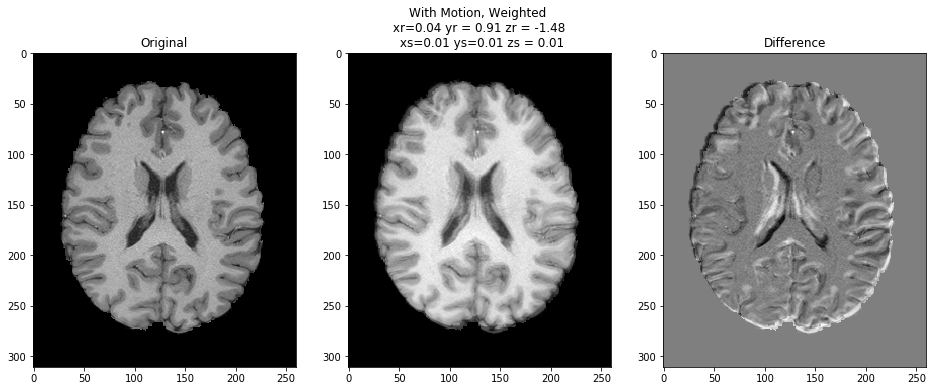

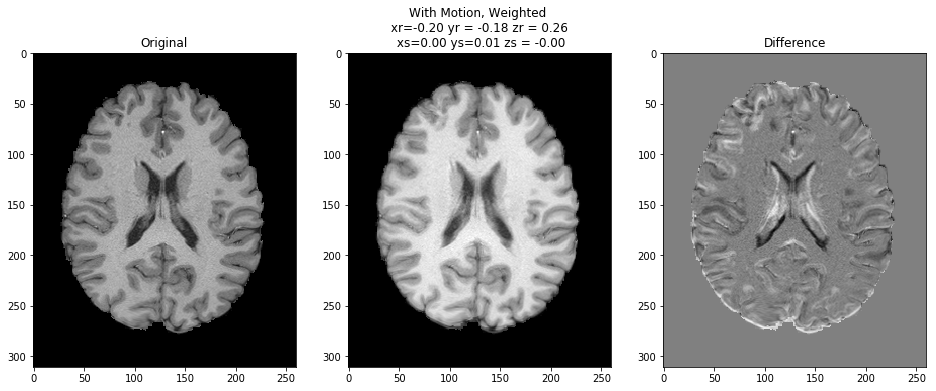

In [740]:
for i,g in enumerate(G):
    [og, cg] = add(in_image, [g], weights = [1])
    
    og = np.fliplr(og)
    og = np.swapaxes(og,0,2)
    
    cg = np.fliplr(cg)
    cg = np.swapaxes(cg,0,2)
    
    
    fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(16,8))
    ax1.imshow(og[130,:,:],cmap='gray');
    ax1.set_title('Original')
    ax2.imshow(cg[130,:,:]/2,cmap='gray');
    titled = 'With Motion, Weighted \n xr=%.2f yr = %.2f zr = %.2f \n xs=%.2f ys=%.2f zs = %.2f' % (samples.iloc[i,3], 
            samples.iloc[i,4],samples.iloc[i,5], samples.iloc[i,0], samples.iloc[i,1], samples.iloc[i,2])
    ax2.set_title(titled)
    ax3.imshow(og[130,:,:] - cg[130,:,:]/2,cmap='gray')
    ax3.set_title('Difference')
    plt.show()

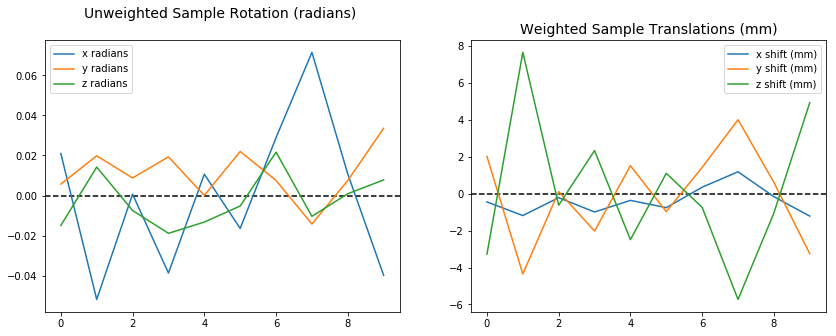

In [741]:
# unweighted rotations
weight = 10
samples = weight*mvn.rvs(size=10)
samples = pd.DataFrame(samples,columns=['xrad','yrad','zrad','xshift','yshift','zshift'])

for l in np.arange(len(samples)):
    
    ig = in_image
    og = ''.join([out_dir,'TransformedImage.Weighted.{:}.{:}.nii.gz'.format(weight,l+1)])
    oxfm = ''.join([out_dir,'Transformation.Weighted.{:}.{:}.mat'.format(weight,l+1)])
    
    make_affine.makeFslXfmMatrix(np.asarray(samples.iloc[l,3:6]), 
                                 np.asarray(samples.iloc[l,0:3]), 
                                 np.asarray([1,1,1]), oxfm)
    
    fsl_wrappers.flirt(in_image, in_image, og, oxfm)

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(14,5))
ax1.axhline(y=0,c='k',linestyle='--')
ax1.plot(samples['xrad'], label='x radians')
ax1.plot(samples['yrad'], label='y radians')
ax1.plot(samples['zrad'], label='z radians')
ax1.legend()
ax1.set_title('Unweighted Sample Rotation (radians) \n ', fontsize=14)

ax2.axhline(y=0,c='k',linestyle='--')
ax2.plot(samples['xshift'], label='x shift (mm)')
ax2.plot(samples['yshift'], label='y shift (mm)')
ax2.plot(samples['zshift'], label='z shift (mm)')
ax2.legend()
ax2.set_title('Weighted Sample Translations (mm)', fontsize=14)

G = glob('/Users/kristianeschenburg/Desktop/transformation_testing/TransformedImage.Weighted.{:}.*.gz'.format(weight))

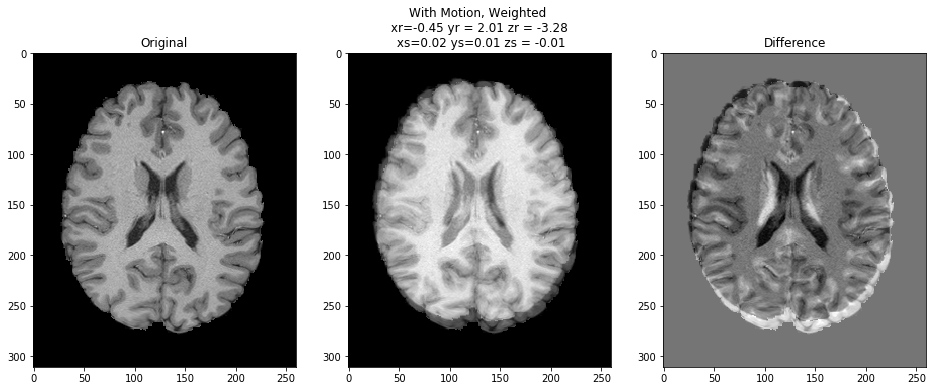

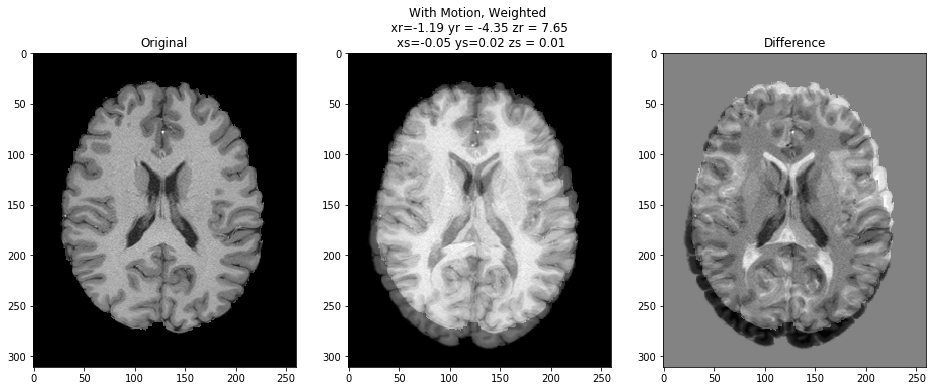

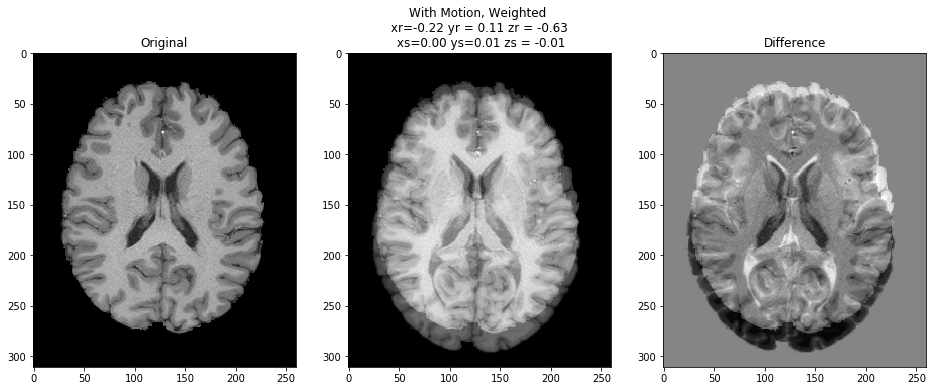

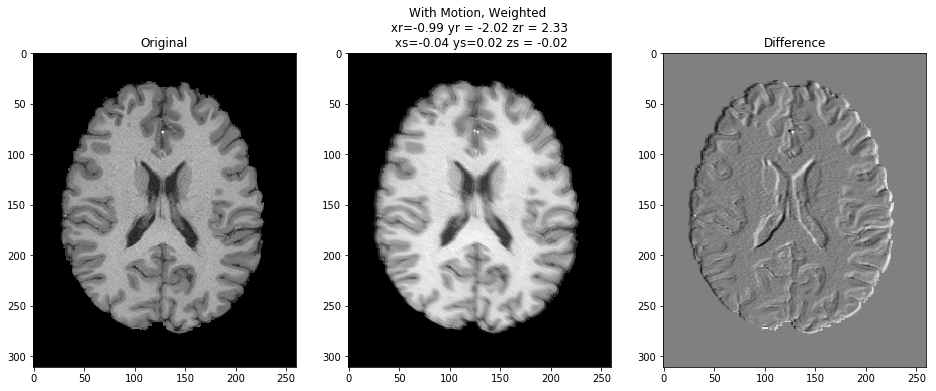

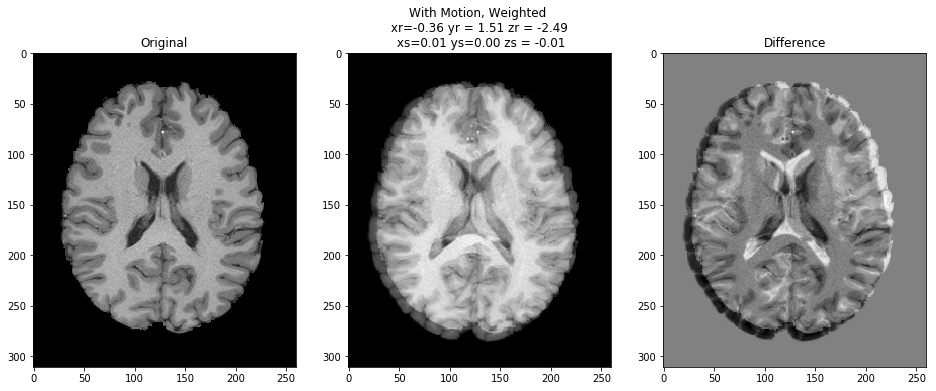

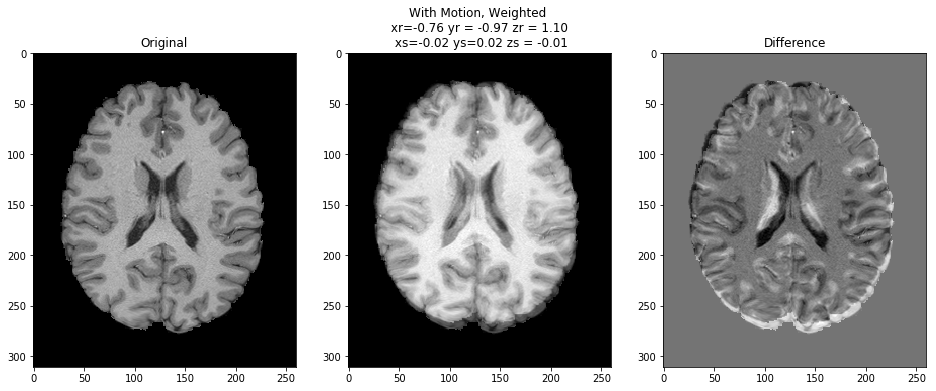

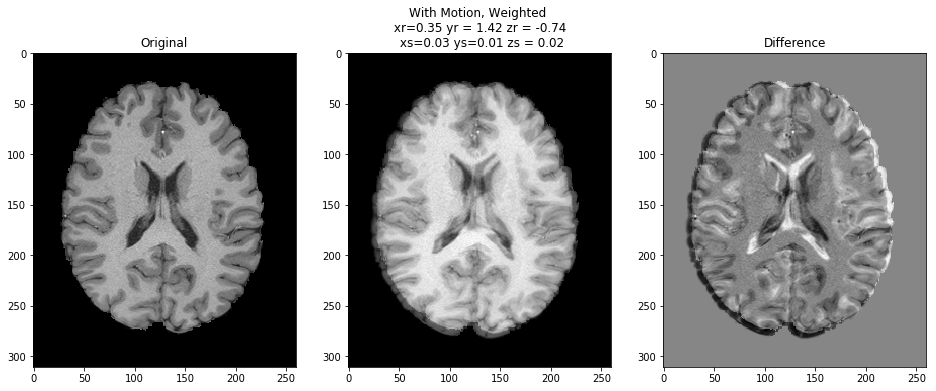

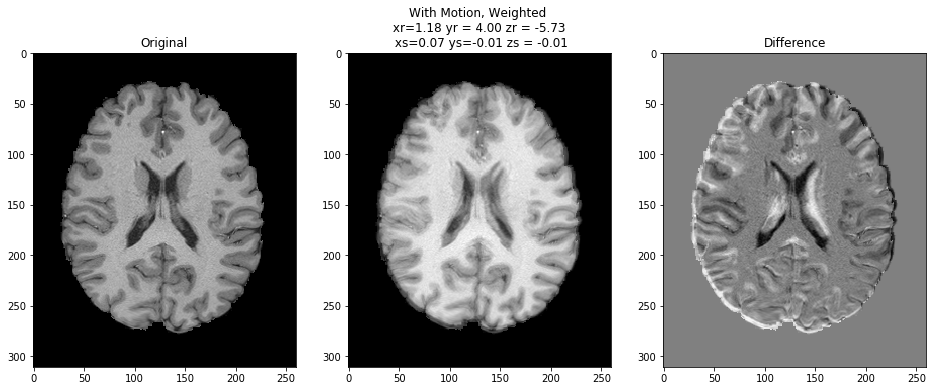

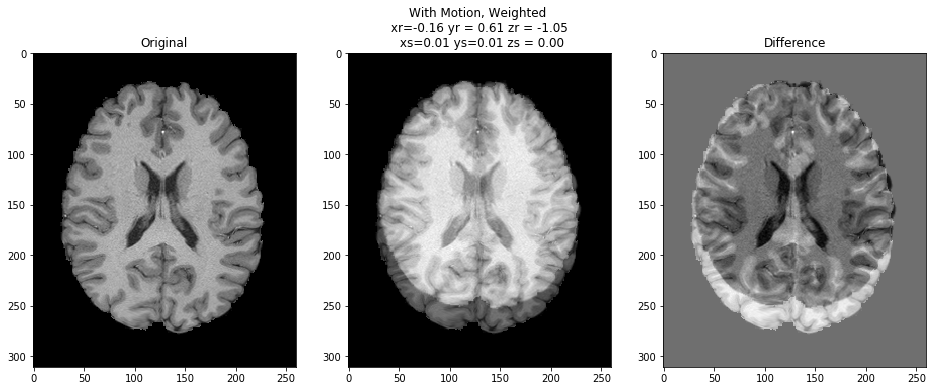

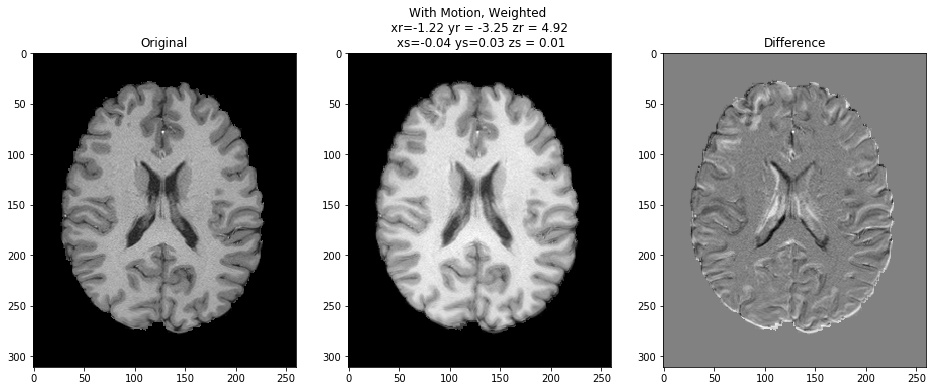

In [742]:
for i,g in enumerate(G):
    [og, cg] = add(in_image, [g], weights = [1])
    
    og = np.fliplr(og)
    og = np.swapaxes(og,0,2)
    
    cg = np.fliplr(cg)
    cg = np.swapaxes(cg,0,2)
    
    
    fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(16,8))
    ax1.imshow(og[130,:,:],cmap='gray');
    ax1.set_title('Original')
    ax2.imshow(cg[130,:,:]/2,cmap='gray');
    titled = 'With Motion, Weighted \n xr=%.2f yr = %.2f zr = %.2f \n xs=%.2f ys=%.2f zs = %.2f' % (samples.iloc[i,3], 
            samples.iloc[i,4],samples.iloc[i,5], samples.iloc[i,0], samples.iloc[i,1], samples.iloc[i,2])
    ax2.set_title(titled)
    ax3.imshow(og[130,:,:] - cg[130,:,:]/2,cmap='gray')
    ax3.set_title('Difference')
    plt.show()

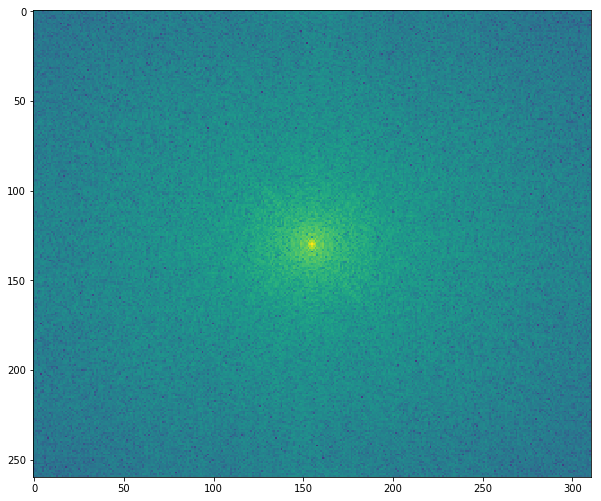

In [783]:
fft = np.fft.fft2(data_slice)
shift_fft = np.fft.fftshift(fft)
fig = plt.figure(figsize=(10,10))
plt.imshow(np.abs(shift_fft),norm=LogNorm(vmin=5))

In [773]:
shift_fft.shape

(260, 311)

In [774]:
shift_fft[129,153] = shift_fft[128,152]

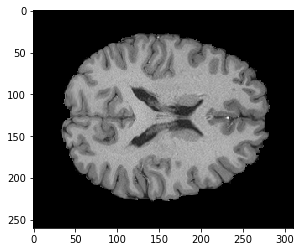

In [775]:
invshift_fft = np.fft.ifftshift(shift_fft)
ifft = np.fft.ifft2(inv_shift)
recon = np.abs(ifft)
plt.imshow(recon,cmap='gray')

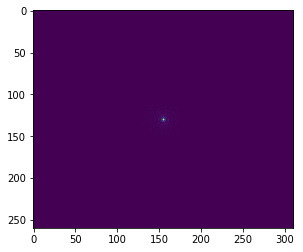

In [784]:
plt.imshow(np.abs(shift_fft))

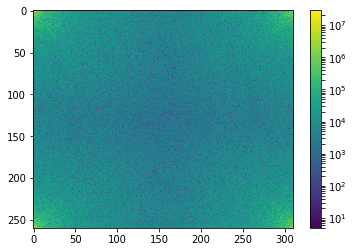

In [790]:
plt.imshow(np.abs(fft),norm=LogNorm(vmin=5)); plt.colorbar()

In [836]:
f = np.fft.fft2(data_slice)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

In [ ]:
rows, cols = data_slice.shape
crow,ccol = np.int(np.floor(rows/2)) , np.int(np.floor(cols/2))

fshift[crow-1:crow+1, ccol-1:ccol+1] = 0
f_ishift = np.fft.ifftshift(fshift)
plt.imshow(np.abs(fshift))
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

fig = plt.subplots(1,3,figsize=(12,8))
plt.subplot(131),plt.imshow(data_slice, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()